# Hidden Shift Problem

In this notebook, we first introduce the hidden shift problem, and classical and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run it on a simulator and device.

## Contents

1. [The Hidden Shift Problem](#hsp)    
   1.1 [The Hidden Shift Problem](#problem)    
   1.2 [The Classical Solution](#classical-solution)    
   1.3 [The Quantum Solution](#quantum-solution) 
2. [Example](#example)
3. [Qiskit Implementation](#implementation)     
   3.1 [Simulation](#simulation)     
   3.2 [Device](#device)     
4. [Problems](#problems)
5. [References](#references)

## 1. The Hidden Shift Problem<a id='hsp'> </a>

The hidden shift problem is an oracle-based problem where the quantum solution shows exponential speedup. We can model some generally used cryptosystems like Poly1305 and ECC by the hidden shift problem, and it is also employed to benchmark quantum computers and classical simulators.

### 1.1 The Hidden Shift Problem <a id='problem'> </a>

Suppose two functions $f$ and $g$ with a relation $g(x)=f(x \oplus s)$, for some n-bit string $s$. Given an oracle $O$ that encodes $f$ and $g$, how can we find $s$ while accessing the oracle as little as possible?

In [1]:
# Importing Qiskit accounts
from qiskit import IBMQ

# Loading your IBM Quantum accounts
# IBMQ.save_account('token')
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-skku','yonsei-uni','yu-students')

In [2]:
import numpy as np
from qiskit import Aer, QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [3]:
n = 4
s = 2

In [4]:
oracle_g = QuantumCircuit(int(n/2))
oracle_g.cz(0,1)

shift_s = QuantumCircuit(n)
if s%2 == 1:
    shift_s.x(0)
if s%4 - s%2 == 2:
    shift_s.x(1)
if s%8 - s%4 == 4:
    shift_s.x(2)
if s%16 - s%8 == 8:
    shift_s.x(3)

oracle_f = QuantumCircuit(n)
oracle_f.compose(shift_s, inplace=True)
oracle_f.barrier()
oracle_f.compose(oracle_g, qubits=[0,1], inplace=True)
oracle_f.barrier()
oracle_f.cz(0,2)
oracle_f.cz(1,3)
oracle_f.barrier()
oracle_f.compose(shift_s, inplace=True)

oracle_sf = QuantumCircuit(n)
oracle_sf.compose(oracle_g, qubits=[2,3], inplace=True)
oracle_sf.barrier()
oracle_sf.cz(0,2)
oracle_sf.cz(1,3)

In [5]:
circ = QuantumCircuit(n, n)

for i in range(n):
    circ.h(i)
circ.barrier()
circ.compose(oracle_f, inplace=True)
circ.barrier()
for i in range(n):
    circ.h(i)
circ.barrier()
circ.compose(oracle_sf, inplace=True)
circ.barrier()
for i in range(n):
    circ.h(i)
circ.barrier()
for i in range(n):
    circ.measure(i, i)

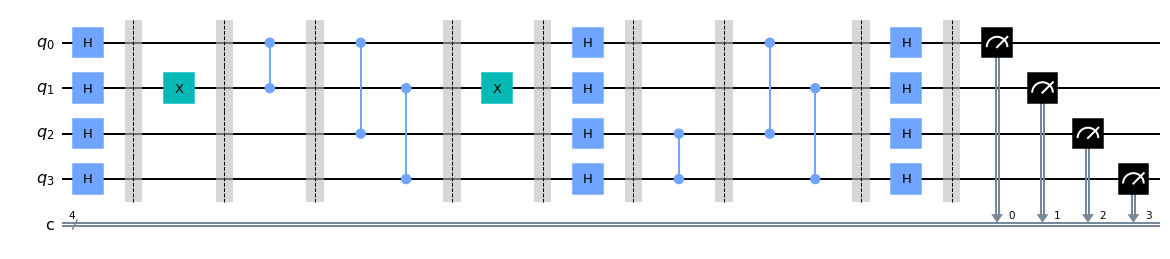

In [6]:
circ.draw('mpl')

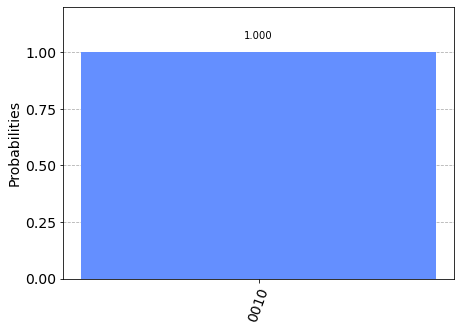

In [7]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circ = transpile(circ, aer_sim)
qobj = assemble(transpiled_circ, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)